# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

In [10]:
import os
from pathlib import Path
import sys


NOTEBOOK_NAME = "C1_M5_Assignment_transferlearning.ipynb" #TODO: automate this
REPO_URL = "https://github.com/SDAIA-Bootcamps/ai-pros-v1-2025.git"

if 'google.colab' in sys.modules:
    print('in colab')
    if os.system('git config --get remote.origin.url') != REPO_URL:
        print('cloning...')
        !git clone $REPO_URL
        repo_dir = REPO_URL.split('/').pop().strip('.git')
        print(f'{repo_dir=}')
        labdir = next(Path(repo_dir).rglob(NOTEBOOK_NAME)).parent.absolute()
        print(f'{labdir=}')
        %cd $labdir

    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

# allow "hot-reloading" of modules
# %load_ext autoreload
# %autoreload 2
# needed for inline plots in some contexts
%matplotlib inline


!pwd
%ls

'pwd' is not recognized as an internal or external command,
operable program or batch file.


 Volume in drive C is Windows
 Volume Serial Number is 668B-1C45

 Directory of c:\Users\janah\OneDrive\??? ??????\SDAIA\week4-Deeplearning\ai-pros-v1-2025

12/01/2026  05:16    <DIR>          .
11/01/2026  01:01    <DIR>          ..
12/01/2026  05:27             4,925 .gitignore
05/01/2026  16:17                 6 .python-version
12/01/2026  15:19         1,741,076 C1_M5_Assignment_transferlearning.ipynb
05/01/2026  16:17               157 pyproject.toml
05/01/2026  16:17                19 README.md
05/01/2026  16:17    <DIR>          W4_DL
               5 File(s)      1,746,183 bytes
               3 Dir(s)  143,728,549,888 bytes free


In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\janah\.cache\kagglehub\datasets\karakaggle\kaggle-cat-vs-dog-dataset\versions\1


In [12]:
# YOUR CODE HERE


import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from torchvision import datasets, models, transforms

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

## Imports

In [69]:
# YOUR CODE HERE

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [13]:
import torch
print(torch.cuda.is_available())


False


In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [72]:
# YOUR CODE HERE

import kagglehub
from pathlib import Path


path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")


data_dir = Path(path)
print("Path to dataset files:", data_dir)


for p in data_dir.iterdir():
    print(p)


Using Colab cache for faster access to the 'kaggle-cat-vs-dog-dataset' dataset.
Path to dataset files: /kaggle/input/kaggle-cat-vs-dog-dataset
/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a


In [73]:
import shutil

pet_images_dir = data_dir / "kagglecatsanddogs_3367a/PetImages"

cat_dir = pet_images_dir / "Cat"
dog_dir = pet_images_dir / "Dog"

cat_dir.mkdir(exist_ok=True)
dog_dir.mkdir(exist_ok=True)

for img_file in pet_images_dir.iterdir():
    if img_file.is_file():
        if "Cat" in img_file.name:
            shutil.move(str(img_file), str(cat_dir / img_file.name))
        elif "Dog" in img_file.name:
            shutil.move(str(img_file), str(dog_dir / img_file.name))


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [74]:
from torchvision import datasets
from torch.utils.data import random_split


full_dataset = datasets.ImageFolder(pet_images_dir)


train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


class_names = full_dataset.classes
print("Classes:", class_names)


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Classes: ['Cat', 'Dog']
Number of training samples: 19967
Number of test samples: 4992


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [75]:
from collections import Counter


train_counts = Counter()
test_counts  = Counter()


for img, label in train_dataset:
    train_counts[class_names[label]] += 1


for img, label in test_dataset:
    test_counts[class_names[label]] += 1

print("Train set counts:", train_counts)
print("Test set counts :", test_counts)


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train set counts: Counter({'Dog': 10023, 'Cat': 9944})
Test set counts : Counter({'Cat': 2546, 'Dog': 2446})


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [76]:
from torchvision import transforms
from torch.utils.data import DataLoader

image_size = 224
batch_size = 32


train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [77]:

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform  = val_transforms


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

print("Classes:", class_names)


Classes: ['Cat', 'Dog']


**Quick Check**: Visualize a batch of training images

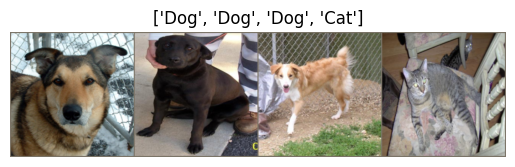

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')


inputs, classes_batch = next(iter(train_loader))


out = torchvision.utils.make_grid(inputs[:4])


imshow(out, title=[class_names[x] for x in classes_batch[:4]])


In [79]:
helper_utils.visualize_batch?

Object `helper_utils.visualize_batch` not found.


In [80]:
# YOUR CODE HERE

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [81]:
# YOUR CODE HERE

import torch
import torch.nn as nn
from torchvision import models


model_ft = models.resnet18(pretrained=True)


for param in model_ft.parameters():
    param.requires_grad = False


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)


print(model_ft)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [82]:
# YOUR CODE HERE
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)


    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }
    return model, history


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [83]:
# YOUR CODE HERE
import torch.optim as optim
from torch.optim import lr_scheduler


criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft, history_conv = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)


Epoch 1/5
--------------------
train Loss: 0.1230 Acc: 0.9523
val Loss: 0.0699 Acc: 0.9752

Epoch 2/5
--------------------
train Loss: 0.0872 Acc: 0.9653
val Loss: 0.0539 Acc: 0.9816

Epoch 3/5
--------------------
train Loss: 0.0740 Acc: 0.9716
val Loss: 0.0512 Acc: 0.9812

Epoch 4/5
--------------------
train Loss: 0.0785 Acc: 0.9678
val Loss: 0.0496 Acc: 0.9838

Epoch 5/5
--------------------
train Loss: 0.0740 Acc: 0.9706
val Loss: 0.0487 Acc: 0.9838

Training complete in 10m 40s
Best val Acc: 0.9838


**Quick Check**: Visualize training history

NameError: name 'history_conv' is not defined

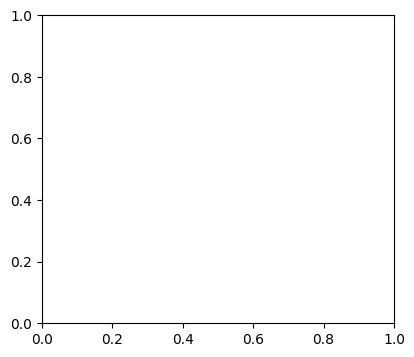

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
plt.plot(range(1, len(history_conv['train_loss'])+1), history_conv['train_loss'], label='Train Loss')
plt.plot(range(1, len(history_conv['val_loss'])+1), history_conv['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1, len(history_conv['train_acc'])+1), history_conv['train_acc'], label='Train Acc')
plt.plot(range(1, len(history_conv['val_acc'])+1), history_conv['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()



In [85]:
# helper_utils.visualize_training_history(history_conv)
# plt.show()

**Quick Check**: Visualize predictions

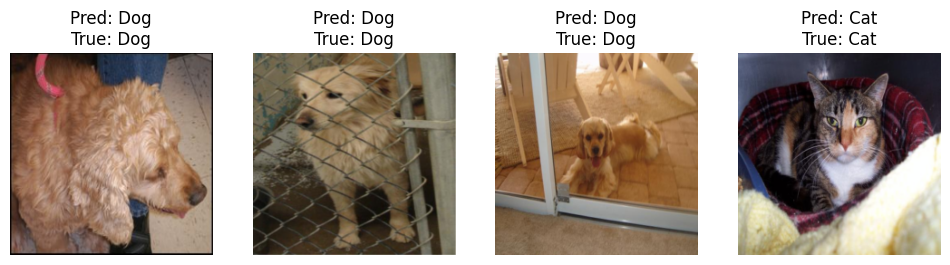

In [86]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(dataloaders['val']))


inputs = inputs.to(device)
outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)


pred_names = [class_names[p] for p in preds]
true_names = [class_names[c] for c in classes]


plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    imshow(inputs.cpu().data[i], title=f'Pred: {pred_names[i]}\nTrue: {true_names[i]}')
plt.show()


In [87]:
# helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [88]:
# YOUR CODE HERE

model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


num_epochs = 5
model_ft, history_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)


Epoch 1/5
--------------------
train Loss: 0.1881 Acc: 0.9362
val Loss: 0.0771 Acc: 0.9810

Epoch 2/5
--------------------
train Loss: 0.0784 Acc: 0.9738
val Loss: 0.0539 Acc: 0.9860

Epoch 3/5
--------------------
train Loss: 0.0641 Acc: 0.9780
val Loss: 0.0435 Acc: 0.9886

Epoch 4/5
--------------------
train Loss: 0.0542 Acc: 0.9805
val Loss: 0.0394 Acc: 0.9900

Epoch 5/5
--------------------
train Loss: 0.0466 Acc: 0.9835
val Loss: 0.0359 Acc: 0.9894

Training complete in 13m 13s
Best val Acc: 0.9900


**Quick Check**: Visualize training history

In [89]:
# helper_utils.visualize_training_history(history_ft)
# plt.show()

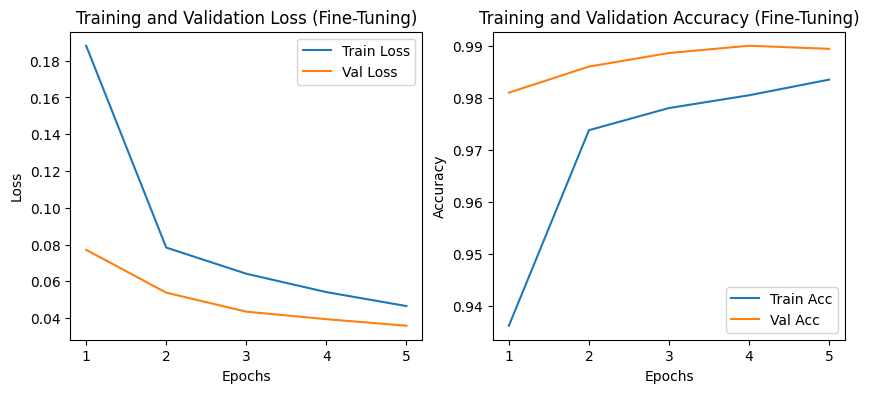

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
plt.plot(range(1, len(history_ft['train_loss'])+1), history_ft['train_loss'], label='Train Loss')
plt.plot(range(1, len(history_ft['val_loss'])+1), history_ft['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Fine-Tuning)')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1, len(history_ft['train_acc'])+1), history_ft['train_acc'], label='Train Acc')
plt.plot(range(1, len(history_ft['val_acc'])+1), history_ft['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Fine-Tuning)')
plt.legend()

plt.show()


**Quick Check**: Visualize predictions

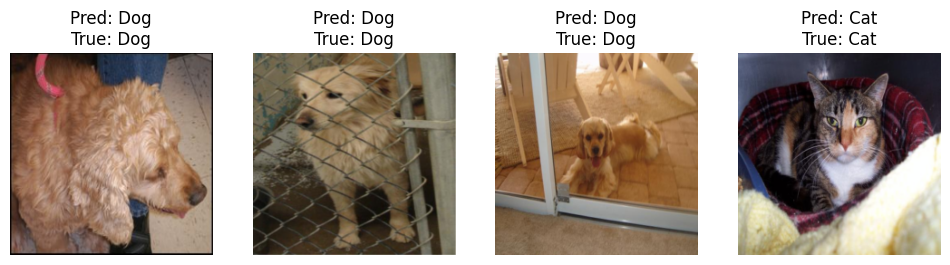

In [91]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')


inputs, classes = next(iter(dataloaders['val']))


inputs = inputs.to(device)
outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)


pred_names = [class_names[p] for p in preds]
true_names = [class_names[c] for c in classes]


plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    imshow(inputs.cpu().data[i], title=f'Pred: {pred_names[i]}\nTrue: {true_names[i]}')
plt.show()


In [92]:
# helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [93]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.


print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
print()
print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.9838
  Final Val Accuracy: 0.9838

Fine-tuning Approach:
  Best Val Accuracy: 0.9900
  Final Val Accuracy: 0.9894


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [94]:
import torchvision.transforms as transforms


data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


Saving 2014467_0.jpg to 2014467_0 (1).jpg


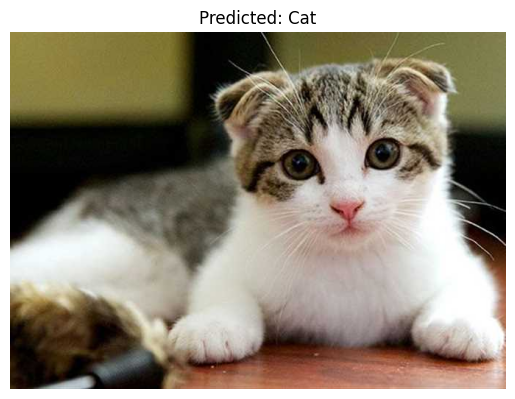

Predicted class: Cat


In [103]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


uploaded = files.upload()
img_path = list(uploaded.keys())[0]


image = Image.open(img_path).convert('RGB')


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = preprocess(image).unsqueeze(0).to(device)

model_ft.eval()
with torch.no_grad():
    output = model_ft(input_tensor)
    _, pred = torch.max(output, 1)
    predicted_class = class_names[pred.item()]


plt.imshow(image)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")



In [96]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [97]:
!pip install onnx onnxruntime onnxscript

In [106]:
import os
print(os.listdir())


['2014467_0 (1).jpg', 'C1_M5_Assignment_transferlearning.ipynb', '2014467_0.jpg', 'helper_utils.py']


In [107]:
model_ft.eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

onnx_path = "resnet18_cats_dogs.onnx"

torch.onnx.export(
    model_ft,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

print("ONNX model saved successfully")


/tmp/ipython-input-3551330733.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
ONNX model saved successfully


In [108]:
!ls

'2014467_0 (1).jpg'			   helper_utils.py
 2014467_0.jpg				   resnet18_cats_dogs.onnx
 C1_M5_Assignment_transferlearning.ipynb   resnet18_cats_dogs.onnx.data


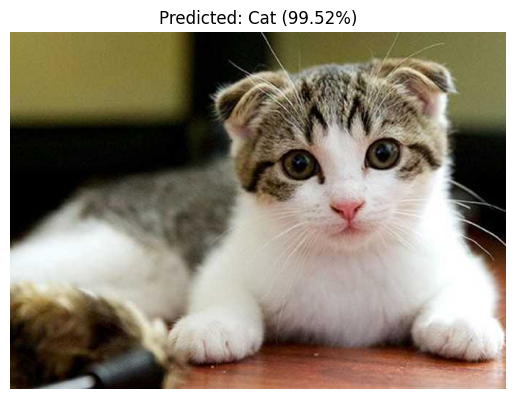

In [109]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class_names = ['Cat', 'Dog']

ort_session = ort.InferenceSession("resnet18_cats_dogs.onnx")

img_path = "2014467_0.jpg"
img = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img_tensor = preprocess(img).unsqueeze(0)
img_numpy = img_tensor.numpy()

outputs = ort_session.run(None, {"input": img_numpy})
preds = outputs[0][0]

probs = np.exp(preds) / np.sum(np.exp(preds))
idx = np.argmax(probs)

plt.imshow(img)
plt.title(f"Predicted: {class_names[idx]} ({probs[idx]*100:.2f}%)")
plt.axis("off")
plt.show()


In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")